# Learning Weights and Connections Implementation 

Since the Learning Weights paper is very low on details I'll be cross-referencing these three papers:
1. Learning both weights and connections: https://arxiv.org/abs/1510.00149 
2. Deep Compression: https://arxiv.org/abs/1506.02626
3. DenseSparseDense: https://arxiv.org/abs/1607.04381

The pruning process is:
    1. Train the model normally
    2. Loop through all the layers and prune connections under a certain threshold
    3. Retrain
    4. Go back to step 2 until accuracy decreases
    
In paper (2) they say that they choose the threshold by multiplying a "quality parameter" by the standard deviation of the layer's weights. Not sure what the quality parameter is but this implies that pruning is done layer by layer, rather than just by saying "remove 90% of the weights in the network". EDIT: I read another paper, DenseSparseDense where they use a Taylor expansion of the error to estimate the cost of pruning certain weights - I'm pretty certain this is what they mean by quality parameter.

We'll start with LeNet-5 because it doesn't have anything too fancy going on. I'm pretty sure this won't be too hard to extend to other layers like BatchNorm, but I'm not entirely what we do to e.g. the gamma/beta params BatchNorm learns. 


To do list:
1. Write calculation for layer sparsity ratio
2. Check pruning on conv layers
3. Do Le-Net example
4. Extend pruning to BatchNorm
5. Do MobiLeNet
6. Figure out how to automate pruning process

## Setup stuff

In [1]:
# Thanks to https://github.com/kuangliu/pytorch-cifar/blob/master/models/lenet.py

import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

Since we're doing this in a notebook, let's load some pretrained weights. I trained this Le-Net model over 150 epochs (probably overkill) using SGD and a decaying learning rate of 0.1 with exponential decay. Batch Size 100 and L2 regularisation (decay=1e-4).

In [2]:
import torch

import torch.optim as optim
from torch.autograd import Variable

import numpy as np

use_cuda=False

model_name, model_wts = 'LeNet', LeNet()

filename = './ckpt_' + model_name + '.t7'
checkpoint = torch.load(filename, map_location=lambda storage, loc: storage)

best_acc = checkpoint['acc']

# Hacky fix for weird load_state_dict error, sorry.
state_dict = checkpoint['model']
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

# load params
model_wts.load_state_dict(new_state_dict)
model_name = model_name + 'dc'

print("Checkpoint loaded with best_acc: ", best_acc)


Checkpoint loaded with best_acc:  72.13


In [3]:
import torchvision
import torchvision.transforms as transforms

print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



# Training
def train(model_name, model, epoch, optimizer):
    if use_cuda:
        model.cuda()
        model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
        cudnn.benchmark = True
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        
        _, predicted = torch.max(outputs.data, 1)
        total   += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
    print( 'Epoch: ', epoch, ' | Loss: ', (train_loss/(batch_idx+1)), ' | Acc: ', 100.*correct/total)

        
        
def test(model_name, model):
    #model_name, model = model[0], model[1]
    if use_cuda:
        model.cuda()
        model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
        cudnn.benchmark = True
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.data[0]
        
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    print( 'Test:  | Loss: ', (test_loss/(batch_idx+1)), ' | Acc: ', 100.*correct/total)
        
        
def retrain(model_name, model, optimizer, retraining_epochs, scheduler):
    for epoch in range(0, retraining_epochs):
        train(model_name, model, epoch, optimizer)
        test(model_name, model)
    return model

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


## What do the weights look like before sparsifying?

First let's think about how the neural network gets represented by tensors.  

As a reminder of the LeNet architecture:

    conv1 = Conv2d(3, 6, 5)  
    conv2 = Conv2d(6, 16, 5)  
    fc1   = Linear(400, 120)  
    fc2   = Linear(120, 84)  
    fc3   = Linear(84, 10)  

So for example, `conv1` has 3 input channels, 6 output channels and uses 5 by 5 filters. Therefore the layer.parameters() for `conv1` has shape `[6, 3, 5, 5]` (I think). Let's verify:

In [4]:
def print_layer_sizes(model):
    for idx, m in enumerate(model.modules()):
        if idx > 0: # ignore the first module - contains all the layers
            print(idx, '->', m)
            for name, param in m.named_parameters():
                print(name, '->', param.data.shape)
            print('\n\n\n')

In [5]:
def get_num_params(model):
    total = 0
    for param in model.parameters():
        total += (param.view(-1)).size()
    return total

get_num_params(model_wts)

TypeError: unsupported operand type(s) for +=: 'int' and 'torch.Size'

Now we do a little bit of investigation into what the weights actually look like. We used L2 regularisation (as per the paper) during training so they *should* gather around zero. 


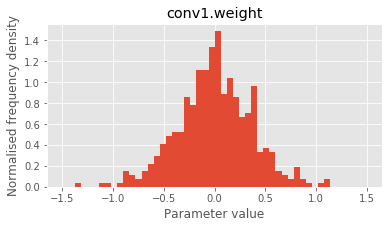

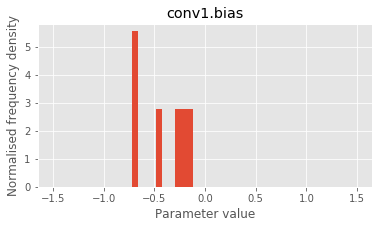

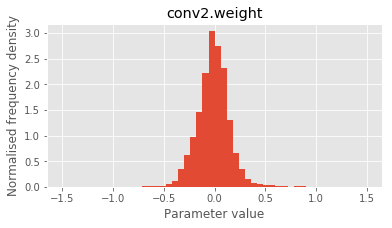

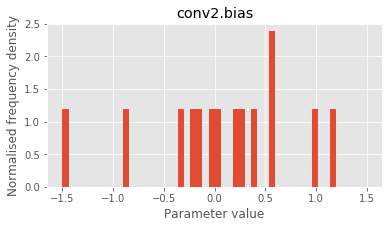

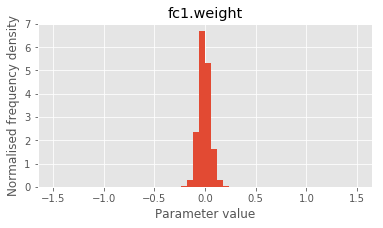

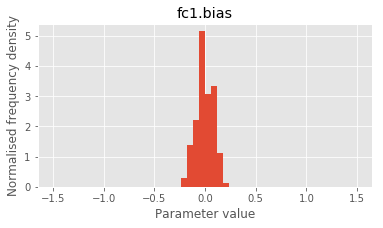

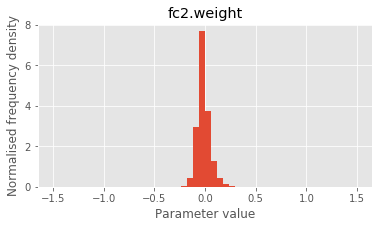

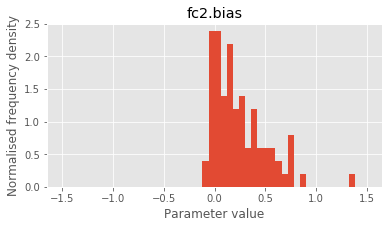

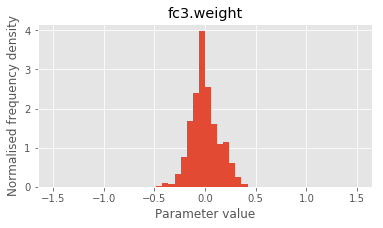

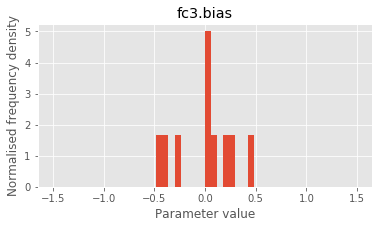

In [6]:
model = model_wts


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_param_histogram(param, name, fig_size=(6, 3), interval=[-1.5, 1.5]):
    """Plots a normalised histogram of an array of parameter values."""
    
    # convert the param to numpy for plotting 
    param = param.data.numpy()
    
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
    ax.hist(param.flatten(), 50, interval, normed=True)
    ax.set_title(name)
    ax.set_xlabel('Parameter value')
    ax.set_ylabel('Normalised frequency density')
    return fig, ax
    
    
'''
In PyTorch, calling model.modules() returns a generator over all of the modules in the network.
The first of these is the model itself, containing all of the layers, and the rest contain the layers individually.
This means that if we just take the first module and iterate over its parameters, this is equivalent to iterating
over the layers.
'''

def plot_histograms(model):
    for idx, m in enumerate(model.modules()):
        if (idx == 0):
            #print(idx, '->', m)
            for name, param in m.named_parameters():
                #print("LAYER: ", name)
                #print("\tMean: ", torch.mean(param.data))
                #print("\tVar:  ", torch.var(param.data))
                #print("\tStd:  ", torch.std(param.data),'\n')
                plot_param_histogram(param, name)
        
    
plot_histograms(model)

Cool!

So now we have a way to iterate over the layers and we know what they looked like before pruning, lets try iteratively removing small weights.

    
I'm still not really sure what the "quality parameter" Han mentions is:

*"the pruning threshold is chosen as a quality parameter multiplied by the standard deviation of a layer’s weights."*

So I'm just going to do a bunch of experiments and see what works. I wonder if Han found a way to quantify the effect that pruning would have on (the quality of the network) accuracy.  


## Benchmarking Inference Time: Before Pruning 


Let's take a look at accuracy and inference time over the test set. Mine takes 1.62s and gets ~72% accuracy. 

In [7]:
criterion = nn.CrossEntropyLoss()
%time test(model_name, model_wts)

Test:  | Loss:  0.8150327754020691  | Acc:  72.13
CPU times: user 5.58 s, sys: 95 ms, total: 5.67 s
Wall time: 2.12 s


## Pruning weights

In [8]:
def calculate_threshold(weights, ratio):
    return np.percentile(np.array(torch.abs(weights)), ratio)


def sparsify(model, threshold=50.):
    for name, param in model.named_parameters():
        if 'weight' in name:
            param.data = (param * torch.gt(torch.abs(param), calculate_threshold(param.data, threshold)).float()).data
    return model



# Set some hyperparameters
quality_param     = 0.
retraining_epochs = 10
learning_rate     = 0.1 
threshold         = 90.

model_wts = sparsify(model_wts, threshold)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_wts.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

model_wts = retrain(model_name, model_wts, optimizer, retraining_epochs, scheduler)



Epoch: 0
Epoch:  0  | Loss:  1.7875568087100984  | Acc:  34.646
Test:  | Loss:  1.513649170398712  | Acc:  46.09

Epoch: 1
Epoch:  1  | Loss:  1.500701544046402  | Acc:  45.858
Test:  | Loss:  1.3572933197021484  | Acc:  51.69

Epoch: 2
Epoch:  2  | Loss:  1.3942975392341614  | Acc:  50.26
Test:  | Loss:  1.275031026005745  | Acc:  55.13

Epoch: 3
Epoch:  3  | Loss:  1.314741729259491  | Acc:  52.856
Test:  | Loss:  1.19774671792984  | Acc:  57.58

Epoch: 4
Epoch:  4  | Loss:  1.2534894077777863  | Acc:  55.282
Test:  | Loss:  1.1535548931360244  | Acc:  59.39

Epoch: 5
Epoch:  5  | Loss:  1.2098370646238328  | Acc:  56.958
Test:  | Loss:  1.1092179661989212  | Acc:  60.88

Epoch: 6
Epoch:  6  | Loss:  1.17613074862957  | Acc:  58.268
Test:  | Loss:  1.0756162369251252  | Acc:  62.31

Epoch: 7
Epoch:  7  | Loss:  1.1375426567792892  | Acc:  59.86
Test:  | Loss:  1.044906188249588  | Acc:  63.33

Epoch: 8
Epoch:  8  | Loss:  1.1111120165586472  | Acc:  60.8
Test:  | Loss:  1.0217425072

## Pruning nodes

In `conv1` the `6` in `[6, 3, 5, 5]` represents the fact that we have 6 kernels/filters. I suppose we could attempt to reduce the filter sizes (i.e. if the edges of a 5 by 5 filter are close to zero or zero, we could swap it out for a 3 by 3 filter), but for now I'll just ignore this. The only number we're interested in iterating over is the 6 so we'll just go in a for loop, calculating whether or not the node can be pruned:


    for kernel in layer:
        if torch.sum(kernel) == 0.:
            layer = remove(kernel, layer)


Note that any time we remove a kernel, we also need to remove the bias associated with it.
  
  
Now let's think about fully connected layers. `fc1` is of shape `[120, 400]`. This means there are 400 incoming connections and 120 outgoing connections. Remember that the last convolutional layer outputs 16 feature maps using 5 b 5 filters, and that these get flattened (into 400 neurons). So all we have to do is iterate over the neurons and remove any that are zero. 


    for neuron in layer:
        if torch.sum(neuron) == 0.:
            layer = remove(neuron, layer)


We also need to keep track of how many neurons we remove from each layer so we know how many inputs the next layer has. This implies that we need to prune all the layers one by one and construct new layers right at the end.

It's probably worth putting some visuals in here.

In [12]:
def compress_matrix(x):

    if len(x.shape) != 2:
        A, B, C, D = x.shape
        x = x.reshape(A * B,  C * D)
        # remove non-necessary filters and rows
        x = x[:, (x != 0).any(axis=0)]
        x = x[(x != 0).any(axis=1), :]
    else:
        # remove unnecessary rows, columns
        x = x[(x != 0).any(axis=1), :]
        x = x[:, (x != 0).any(axis=0)]
    
    return x


def prune_nodes(layer):
    
    pruned_weights = []
    prune_bias     = []
    pruned_indices = []
    
    weights = layer.weight.data
    biases  = layer.bias.data
    
    for idx, w in enumerate(weights):
        if torch.sum(w) == 0.:
            # These could be compressed into one, but for clarity we will leave them separate.
            prune_bias.append(True)
            pruned_indices.append(idx)      
        else:
            pruned_weights.append(w.numpy())
            prune_bias.append(False)
    
    new_biases = []
    
    for b, prune in zip(biases, prune_bias):
        if not prune:
            new_biases.append(b)
            
    
    num_outputs  = len(pruned_weights)
    
    # This operation will fail if there are no biases (i.e. ALL of our neurons have been pruned). 
    # Need to think about appropriate way to handle this ... may be the case that we can prune the entire layer?
    new_biases   = torch.from_numpy(np.array(new_biases).T)
    new_weights  = torch.from_numpy(np.array(pruned_weights))
    
    print(pruned_indices)
    
    return num_outputs, new_weights, new_biases, pruned_indices


def prune_inputs(layer, indices_to_prune):
    
    weights   = layer.weight.data

    pruned_weights = []
    
    for weight in weights:
        new_weight_vector = []
        
        # loop over the weights in the vector. if they need to be pruned then don't add them to new vector
        for idx, elem in enumerate(weight):
            if idx not in indices_to_prune:
                new_weight_vector.append(elem)
                                        
        pruned_weights.append(new_weight_vector)
    
    
    pruned_weights = torch.from_numpy(np.array(pruned_weights))
    
    layer.weight.data = pruned_weights
    
    return layer

## Example: Pruning LeNet

            self.conv1 = nn.Conv2d(3, 6, 5)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1   = nn.Linear(16*5*5, 120)
            self.fc2   = nn.Linear(120, 84)
            self.fc3   = nn.Linear(84, 10)

[]
[]
[0, 28, 34, 67, 81, 82]
1 -> Conv2d (3, 6, kernel_size=(5, 5), stride=(1, 1))
weight -> torch.Size([6, 3, 5, 5])
bias -> torch.Size([6])




2 -> Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
weight -> torch.Size([16, 6, 5, 5])
bias -> torch.Size([16])




3 -> Linear(in_features=400, out_features=120)
weight -> torch.Size([120, 400])
bias -> torch.Size([120])




4 -> Linear(in_features=120, out_features=78)
weight -> torch.Size([78, 120])
bias -> torch.Size([78])




5 -> Linear(in_features=84, out_features=10)
weight -> torch.Size([10, 78])
bias -> torch.Size([10])






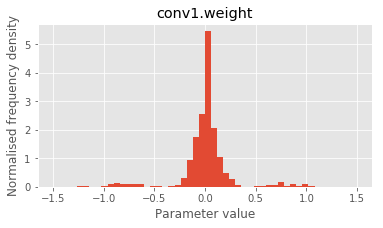

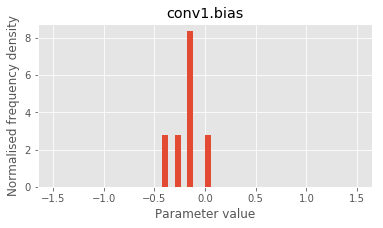

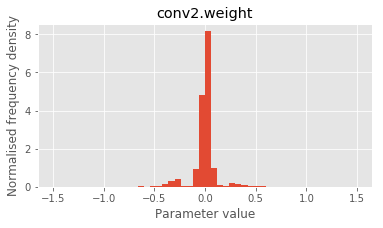

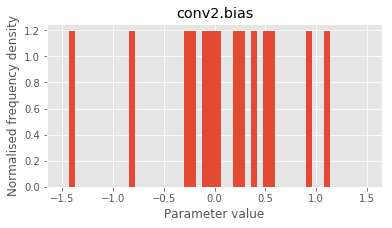

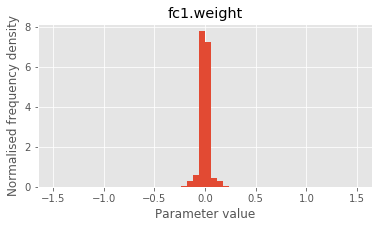

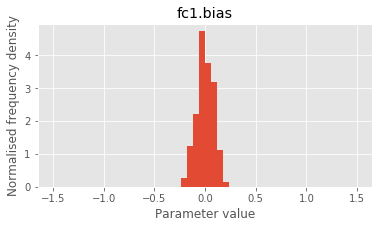

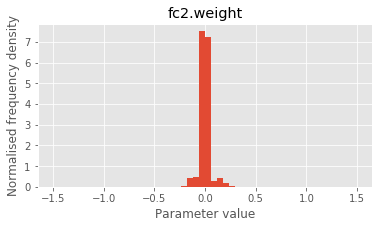

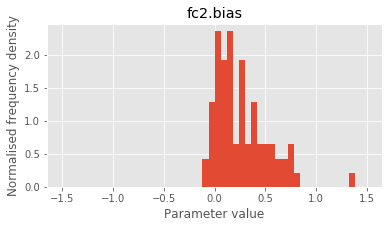

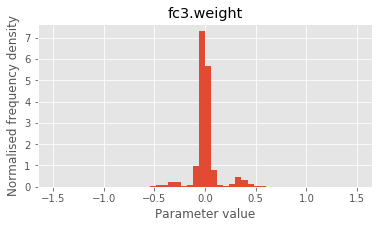

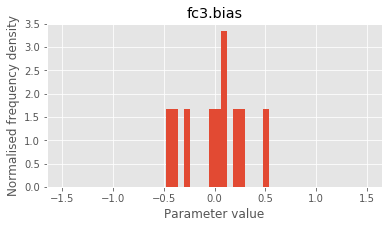

In [13]:
import copy

model = copy.deepcopy(model_wts)

def get_layer(index, model):
    for idx, m in enumerate(model.modules()):
        if (idx == index):
            return m

# If we subclass original LeNet we should be able to use the same 'forward' method
class LeNet2(LeNet):
    def __init__(self, conv1, conv2, fc1, fc2, fc3):
        super(LeNet2, self).__init__()
        self.conv1 = conv1
        self.conv2 = conv2
        self.fc1   = fc1
        self.fc2   = fc2
        self.fc3   = fc3


def prune_lenet(model):
    
    # We don't want to prune the input layer
    
    conv1 = get_layer(1, model)
    conv2 = get_layer(2, model)
    fc1   = get_layer(3, model)
    fc2   = get_layer(4, model)
    fc3   = get_layer(5, model)
    
    
    # Fortunately for us the kernel size is fixed
    kernel_size = 5
    
    ''' CONV 1 '''
    conv1_c = conv1
    num_outputs = conv1_c.weight.data.shape[0]
    
    
    ''' CONV 2 '''
    num_inputs  = num_outputs
    num_outputs, new_weights, new_biases, pruned_indices = prune_nodes(conv2)
    
    print("conv2: ", pruned_indices)
    
    conv2_c     = nn.Conv2d(num_inputs, num_outputs, kernel_size)
    conv2_c.weight.data = new_weights
    conv2_c.bias.data   = new_biases
    
    
    # need to do something fancy to the pruned_indices to translate it to fc mode 
    original_vec_size = 400
    vec_size          = num_outputs * kernel_size * kernel_size
    
    # if we pruned filter one (there were sixteen), then new_vec_size = 375
    # we need to change pruned_ind from [1] to [1..25]
    p = []
    feature_size = kernel_size * kernel_size
    for index in pruned_indices:
        end      = index * feature_size
        start    = end   - feature_size
        p.append(list(range(start, end)))


    pruned_indices = [item for sublist in p for item in sublist]
    
    ''' FC 1 '''
    fc1 = prune_inputs(fc1, pruned_indices)
    
    num_inputs = num_outputs * kernel_size * kernel_size
    num_outputs, new_weights, new_biases, pruned_indices = prune_nodes(fc1)
    
    print('fc1: ', pruned_indices)
    fc1_c = nn.Linear(num_inputs, num_outputs)
    fc1_c.weight.data = new_weights
    fc1_c.bias.data   = new_biases

    
    
    ''' FC2'''
    num_inputs = num_outputs
    fc2_p = prune_inputs(fc2, pruned_indices)
    
    num_outputs, new_weights, new_biases, pruned_indices = prune_nodes(fc2_p)
    
    fc2_c = nn.Linear(num_inputs, num_outputs)
    fc2_c.weight.data = new_weights
    fc2_c.bias.data   = new_biases
    
    
    
    ''' FC3 '''
    ''' Don't want to prune whole nodes from the final layer '''
    num_inputs = num_outputs
    fc3_c = prune_inputs(fc3, pruned_indices)
    
    
    model_compressed = LeNet2(conv1_c, conv2_c, fc1_c, fc2_c, fc3_c)

    return model_compressed

model_c = prune_lenet(model)

model_c = model_c.float()


print_layer_sizes(model_c)
plot_histograms(model_c)


## Benchmarking Inference Time: After Pruning

In [15]:
%time test(model_name, model_wts)
print('\n\n\n')
%time test(model_name, model_c)

Test:  | Loss:  1.0056160360574722  | Acc:  64.77
CPU times: user 1.1 s, sys: 160 ms, total: 1.26 s
Wall time: 908 ms




Test:  | Loss:  1.0056160473823548  | Acc:  64.77
CPU times: user 1.39 s, sys: 206 ms, total: 1.6 s
Wall time: 1.18 s


## Investigation: Pruning Ratio vs Speedup

Going to do the same thing we did before but for AlexNet instead of LeNet. 

In [9]:
model = model_wts

import numpy as np
def count_params(model):
    total = 0
    for param in model.parameters():
        flat = param.view(param.size(0), -1)
        flat = flat.data
        total = total + np.count_nonzero(flat)
    return total


count_params(model)

62006